# WORLD POPULATION 

## Melanie Lum, Pranav Salunke, Srijitha Somangili

Required installs: “pip install selenium” and “conda install phantomjs”, “pip install geopandas”, “pip install mapclassify”, “pip install descartes”, “pip install pypi”


## Reformating Original Data

Note: In our submission, we have all of the reformatted data sets so running the reformat cells will just overwrite them with the same contents.

### formatPop.py

Reads in original UN Population data `WPP2017_TotalPopulationBySex.csv` and reformats to a more structured format

In [2]:
# script to break up and reformat the population data

import csv
import time

ORIG_DATA = "data/WPP2017_TotalPopulationBySex.csv"


# helper function to write the three rows per location
def writeLocRows(filename, trackingVars, data):
    currLocID,currLoc, currVar = trackingVars
    maleData, femaleData, totalData = data

    rows = []
    # remember new header: ["LocationID","Location", "Variant", "Group", 1959, ..., 2100]
    # male data
    maleRow = [currLocID,currLoc, currVar, "Male"] + maleData
    rows.append(maleRow)
    # female data
    femaleRow = [currLocID,currLoc, currVar, "Female"] + femaleData
    rows.append(femaleRow)
    # total data
    totalRow = [currLocID,currLoc, currVar, "Total"] + totalData
    rows.append(totalRow)

    # print(maleRow)
    # print(femaleRow)
    # print(totalRow)

    # write all the rows
    with open(filename, "a", newline="") as newFile:
        # append to the new file
        newWriter = csv.writer(newFile)
        newWriter.writerows(rows)


# break the original file into other, reformated files
# we ignore midPeriod, and ID values in the reformatted files
with open(ORIG_DATA, "r") as origdata:
    baseFile = "data/TotalPopulation_[[VARIANT]].csv"  # [[VARIANT]] will be replaced
    origReader = csv.reader(origdata)
    header = next(origReader)
    # print(header)

    # Group is Male, Female, or Total
    newHeader = ["LocationID","Location", "Variant", "Group"]
    # create years
    for y in range(1950, 2101):  # data has year range 1950-2100
        newHeader.append(y)
    # print(newHeader)

    # read first line and set initial values for tracking variables
    firstLine = next(origReader)
    # tracking variables
    currLocID = firstLine[0]
    currLoc = firstLine[1]
    currVar = firstLine[3]
    var = firstLine[3].title().replace(" ", "")  # make "Hello world"  to "HelloWorld"
    currFileName = baseFile.replace("[[VARIANT]]", var)
    print("Now writing to: %s" % (currFileName))
    # print(currFileName)

    # write new header
    with open(currFileName, "w", newline="") as newFile:
        newWriter = csv.writer(newFile)
        newWriter.writerow(newHeader)

    # data in orig is a column from 1950-2100, we make it part of the row
    # data of population values per year
    # each of these is for one country/location
    maleData = [firstLine[6]]
    femaleData = [firstLine[7]]
    totalData = [firstLine[8]]

    # read in all the other lines
    for line in origReader:
        # print(line)

        # set tracking vars
        lineLocID = line[0]
        lineLoc = line[1]
        lineVar = line[3]

        if lineLoc != currLoc:  # new location

            # write location data
            trackingVars = (currLocID,currLoc, currVar)
            data = (maleData, femaleData, totalData)
            writeLocRows(currFileName, trackingVars, data)

            # reset tracker for location
            currLocID = lineLocID
            currLoc = lineLoc

            # and reset data lists
            maleData.clear()
            femaleData.clear()
            totalData.clear()

        if lineVar != currVar:  # new variant, want to make new file
            # the way the orig data is done, if the variant changes, so does the location
            #   which means the location block above is also run

            # create new file name
            var = line[3].title().replace(" ", "")  # make "Hello world"  to "HelloWorld"
            currFileName = baseFile.replace("[[VARIANT]]", var)
            print("Now writing to: %s" % (currFileName))

            # write new header to new file
            with open(currFileName, "w", newline="") as newFile:
                newWriter = csv.writer(newFile)
                newWriter.writerow(newHeader)

            # reset tracking variables
            # currLoc already set in location block above
            currVar = lineVar

            # data lists already cleared in location block above

        # add the populations to the data list
        # will be empty if needed (ie. new variant or new location)
        maleData.append(line[6])
        femaleData.append(line[7])
        totalData.append(line[8])

    # write the stuff that hasnt been written yet ()
    trackingVars = (currLocID,currLoc, currVar)
    data = (maleData, femaleData, totalData)
    writeLocRows(currFileName, trackingVars, data)


Now writing to: data/TotalPopulation_Medium.csv
Now writing to: data/TotalPopulation_High.csv
Now writing to: data/TotalPopulation_Low.csv
Now writing to: data/TotalPopulation_ConstantFertility.csv
Now writing to: data/TotalPopulation_InstantReplacement.csv
Now writing to: data/TotalPopulation_ZeroMigration.csv
Now writing to: data/TotalPopulation_ConstantMortality.csv
Now writing to: data/TotalPopulation_NoChange.csv
Now writing to: data/TotalPopulation_Momentum.csv


## read_fertility

Reads original UN fertility data `Total_fertility.xlsx` and seperates into datasets according to the variants

In [3]:
import re
import xlrd
import csv
import time
import pandas as pd


def read_fertility(variant):
#     variant = "NO CHANGE"
    # possible variant names: "ESTIMATES", "MEDIUM VARIANT", "HIGH VARIANT", "LOW VARIANT", "CONSTANT-FERTILITY",
    # "INSTANT-REPLACEMENT", "MOMENTUM", "ZERO-MIGRATION", "CONSTANT-MORTALITY", "NO CHANGE"

    past = ["Index", "Variant", "Location", "Notes", "Country Code", "1950-1955", "1955-1960",
                  "1960-1965", "1965-1970", "1970-1975", "1975-1980","1980-1985", "1985-1990", "1990-1995",
                  "1995-2000", "2000-2005", "2005-2010", "2010-2015"]
    future = ["Index", "Variant", "Location", "Notes", "Country Code", "2015-2020", "2020-2025", "2025-2030",
              "2030-2035", "2035-2040", "2040-2045", "2045-2050", "2050-2055", "2055-2060", "2060-2065", "2065-2070", 
              "2070-2075", "2075-2080", "2080-2085", "2085-2090", "2090-2095", "2095-2100"]

    if (variant == "ESTIMATES"):
        fert_names = past
    else:
        fert_names = future

# How to make a dataframe
# https://www.geeksforgeeks.org/different-ways-to-create-pandas-dataframe/
    fileName = "data/Total_fertility.xlsx"
    fertDF = pd.read_excel(fileName, sheet_name=variant, skiprows=16, names=fert_names)

    #Read country code list csv file using pandas
    countrycodefile = 'intermediate-data/all-country-list.csv'
    cf = pd.read_csv(countrycodefile, names = ['countryname', 'al2', 'al3code','Country Code','iso','region','subr','intr','rcode','subrcode','intrcode'], skiprows = 1)
    cf.drop(['countryname','al2', 'al3code','iso','subr','intr','rcode','subrcode','intrcode'],axis=1,inplace=True)    

    # Make a dataframe called "common" that is the inner join of the countriesDF and the fertDF
    common = cf.merge(fertDF, how='inner', left_on=['Country Code'], right_on=[ 'Country Code'])
    fertDF = common.drop(columns=["Notes", "Index"])  # drop countries since same as location and notes section
    to_replace = r'[ -]'
    # Save the current dataset as a csv file with the name "Fertility_[Name of variant]" in the data folder
    csv_name = (r'./data/Fertility_%s.csv' % re.sub(to_replace, "", variant.title()))
    fertDF.to_csv(csv_name)
    print(fertDF)
    return fertDF

varlist = ["ESTIMATES", "MEDIUM VARIANT", "HIGH VARIANT", "LOW VARIANT", "CONSTANT-FERTILITY",
    "INSTANT-REPLACEMENT", "MOMENTUM", "ZERO-MIGRATION", "CONSTANT-MORTALITY", "NO CHANGE"]

# read_fertility("MEDIUM VARIANT")
for each in varlist:
    read_fertility(each)

     Country Code    region    Variant                            Location  \
0               4      Asia  Estimates                         Afghanistan   
1               8    Europe  Estimates                             Albania   
2              12    Africa  Estimates                             Algeria   
3              24    Africa  Estimates                              Angola   
4              28  Americas  Estimates                 Antigua and Barbuda   
5              32  Americas  Estimates                           Argentina   
6              51      Asia  Estimates                             Armenia   
7             533  Americas  Estimates                               Aruba   
8              36   Oceania  Estimates                           Australia   
9              40    Europe  Estimates                             Austria   
10             31      Asia  Estimates                          Azerbaijan   
11             44  Americas  Estimates                          

     Country Code    region         Variant  \
0               4      Asia  Medium variant   
1               8    Europe  Medium variant   
2              12    Africa  Medium variant   
3              24    Africa  Medium variant   
4              28  Americas  Medium variant   
5              32  Americas  Medium variant   
6              51      Asia  Medium variant   
7             533  Americas  Medium variant   
8              36   Oceania  Medium variant   
9              40    Europe  Medium variant   
10             31      Asia  Medium variant   
11             44  Americas  Medium variant   
12             48      Asia  Medium variant   
13             50      Asia  Medium variant   
14             52  Americas  Medium variant   
15            112    Europe  Medium variant   
16             56    Europe  Medium variant   
17             84  Americas  Medium variant   
18            204    Africa  Medium variant   
19             64      Asia  Medium variant   
20           

     Country Code    region       Variant                            Location  \
0               4      Asia  High variant                         Afghanistan   
1               8    Europe  High variant                             Albania   
2              12    Africa  High variant                             Algeria   
3              24    Africa  High variant                              Angola   
4              28  Americas  High variant                 Antigua and Barbuda   
5              32  Americas  High variant                           Argentina   
6              51      Asia  High variant                             Armenia   
7             533  Americas  High variant                               Aruba   
8              36   Oceania  High variant                           Australia   
9              40    Europe  High variant                             Austria   
10             31      Asia  High variant                          Azerbaijan   
11             44  Americas 

     Country Code    region      Variant                            Location  \
0               4      Asia  Low variant                         Afghanistan   
1               8    Europe  Low variant                             Albania   
2              12    Africa  Low variant                             Algeria   
3              24    Africa  Low variant                              Angola   
4              28  Americas  Low variant                 Antigua and Barbuda   
5              32  Americas  Low variant                           Argentina   
6              51      Asia  Low variant                             Armenia   
7             533  Americas  Low variant                               Aruba   
8              36   Oceania  Low variant                           Australia   
9              40    Europe  Low variant                             Austria   
10             31      Asia  Low variant                          Azerbaijan   
11             44  Americas  Low variant

     Country Code    region             Variant  \
0               4      Asia  Constant-fertility   
1               8    Europe  Constant-fertility   
2              12    Africa  Constant-fertility   
3              24    Africa  Constant-fertility   
4              28  Americas  Constant-fertility   
5              32  Americas  Constant-fertility   
6              51      Asia  Constant-fertility   
7             533  Americas  Constant-fertility   
8              36   Oceania  Constant-fertility   
9              40    Europe  Constant-fertility   
10             31      Asia  Constant-fertility   
11             44  Americas  Constant-fertility   
12             48      Asia  Constant-fertility   
13             50      Asia  Constant-fertility   
14             52  Americas  Constant-fertility   
15            112    Europe  Constant-fertility   
16             56    Europe  Constant-fertility   
17             84  Americas  Constant-fertility   
18            204    Africa  Co

     Country Code    region              Variant  \
0               4      Asia  Instant-replacement   
1               8    Europe  Instant-replacement   
2              12    Africa  Instant-replacement   
3              24    Africa  Instant-replacement   
4              28  Americas  Instant-replacement   
5              32  Americas  Instant-replacement   
6              51      Asia  Instant-replacement   
7             533  Americas  Instant-replacement   
8              36   Oceania  Instant-replacement   
9              40    Europe  Instant-replacement   
10             31      Asia  Instant-replacement   
11             44  Americas  Instant-replacement   
12             48      Asia  Instant-replacement   
13             50      Asia  Instant-replacement   
14             52  Americas  Instant-replacement   
15            112    Europe  Instant-replacement   
16             56    Europe  Instant-replacement   
17             84  Americas  Instant-replacement   
18          

     Country Code    region   Variant                            Location  \
0               4      Asia  Momentum                         Afghanistan   
1               8    Europe  Momentum                             Albania   
2              12    Africa  Momentum                             Algeria   
3              24    Africa  Momentum                              Angola   
4              28  Americas  Momentum                 Antigua and Barbuda   
5              32  Americas  Momentum                           Argentina   
6              51      Asia  Momentum                             Armenia   
7             533  Americas  Momentum                               Aruba   
8              36   Oceania  Momentum                           Australia   
9              40    Europe  Momentum                             Austria   
10             31      Asia  Momentum                          Azerbaijan   
11             44  Americas  Momentum                             Bahamas   

     Country Code    region         Variant  \
0               4      Asia  Zero-migration   
1               8    Europe  Zero-migration   
2              12    Africa  Zero-migration   
3              24    Africa  Zero-migration   
4              28  Americas  Zero-migration   
5              32  Americas  Zero-migration   
6              51      Asia  Zero-migration   
7             533  Americas  Zero-migration   
8              36   Oceania  Zero-migration   
9              40    Europe  Zero-migration   
10             31      Asia  Zero-migration   
11             44  Americas  Zero-migration   
12             48      Asia  Zero-migration   
13             50      Asia  Zero-migration   
14             52  Americas  Zero-migration   
15            112    Europe  Zero-migration   
16             56    Europe  Zero-migration   
17             84  Americas  Zero-migration   
18            204    Africa  Zero-migration   
19             64      Asia  Zero-migration   
20           

     Country Code    region             Variant  \
0               4      Asia  Constant-mortality   
1               8    Europe  Constant-mortality   
2              12    Africa  Constant-mortality   
3              24    Africa  Constant-mortality   
4              28  Americas  Constant-mortality   
5              32  Americas  Constant-mortality   
6              51      Asia  Constant-mortality   
7             533  Americas  Constant-mortality   
8              36   Oceania  Constant-mortality   
9              40    Europe  Constant-mortality   
10             31      Asia  Constant-mortality   
11             44  Americas  Constant-mortality   
12             48      Asia  Constant-mortality   
13             50      Asia  Constant-mortality   
14             52  Americas  Constant-mortality   
15            112    Europe  Constant-mortality   
16             56    Europe  Constant-mortality   
17             84  Americas  Constant-mortality   
18            204    Africa  Co

     Country Code    region    Variant                            Location  \
0               4      Asia  No change                         Afghanistan   
1               8    Europe  No change                             Albania   
2              12    Africa  No change                             Algeria   
3              24    Africa  No change                              Angola   
4              28  Americas  No change                 Antigua and Barbuda   
5              32  Americas  No change                           Argentina   
6              51      Asia  No change                             Armenia   
7             533  Americas  No change                               Aruba   
8              36   Oceania  No change                           Australia   
9              40    Europe  No change                             Austria   
10             31      Asia  No change                          Azerbaijan   
11             44  Americas  No change                          

## gdp-formatPop.py

Reads in GDP per capita data and reformats into a better structure. We did not end up using this dataset because it did not have data for all of the needed years.

In [4]:
# %load gdp-formatPop.py
# script to break up and reformat the population data

import csv
import time

ORIG_DATA = "data/UNdata_gdp.csv"


# break the original file into other, reformated files
# we ignore midPeriod, and ID values in the reformatted files
with open(ORIG_DATA, "r") as origdata:
    baseFile = "data/formatted-gdp.csv"  # [[VARIANT]] will be replaced
    origReader = csv.reader(origdata)
    header = next(origReader)
    #print(header)

    # Group is Male, Female, or Total
    newHeader = ["Location", "Variant"]
    # create years
    for y in range(1970, 2018):  # data has year range 1950-2100
        newHeader.append(y)
    #print(newHeader)

    # read first line and set initial values for tracking variables
    firstLine = next(origReader)
    print(firstLine)
    # tracking variables
    currLoc = firstLine[0]
    currVar = firstLine[2]

    # write new header
    with open(baseFile, "w", newline="") as newFile:
        newWriter = csv.writer(newFile)
        newWriter.writerow(newHeader)

    # data in orig is a column from 1970-2018, we make it part of the row
    # data of population values per year
    # each of these is for one country/location
    gdpData = [firstLine[3]]

    # read in all the other lines
    for line in origReader:
        #print(line)
        if not line:
            break

        # set tracking vars
        lineLoc = line[0]

        if lineLoc != currLoc:  # new location
            rows = []
            # remember new header: ["Location", "Variant", "Group", 1959, ..., 2100]
            # male data
            print(gdpData)
            gdpData.reverse()
            gdpRow = [currLoc, currVar] + gdpData
            rows.append(gdpRow)
            # write all the rows
            with open(baseFile, "a", newline="") as newFile:
                # append to the new file
                newWriter = csv.writer(newFile)
                newWriter.writerows(rows)
#
            # reset tracker for location
            currLoc = line[0]
#
#            # and reset data lists
            gdpData.clear()
#            femaleData.clear()
#            totalData.clear()
#
#        # add the populations to the data list
#        # will be empty if needed (ie. new variant or new location)
        gdpData.append(line[3])
#        femaleData.append(line[7])
#        totalData.append(line[8])



['Afghanistan', '2017', 'Gross Domestic Product (GDP)', '618.98998960411']
['618.98998960411', '583.883061294723', '610.854544665644', '651.158425556327', '681.034214773945', '694.88561837611', '645.283463513032', '558.199764560644', '448.951917911206', '394.536100939982', '389.985586406749', '290.199323502468', '264.12537117563', '231.642645233113', '213.985766773368', '194.959344303333', '172.681737005666', '175.769495330109', '140.179220417387', '154.365999966844', '164.092893037794', '175.300440225496', '189.262390166143', '130.751050595233', '176.507619568925', '248.518889846771', '257.056193275695', '295.662201132052', '283.775764823496', '230.857451425511', '251.026687652081', '286.232933009294', '281.921913386693', '278.941959444171', '274.385761694002', '269.723948686728', '266.493042327827', '274.88086785191', '277.900737623219', '249.287385819297', '226.005343006637', '199.02617304863', '187.975603797374', '174.94203852968', '144.110319843264', '136.11701491438', '160.372836

## Utility 

### Load GeneralGifs

In [12]:
# %load generalGifs.py
import os
import imageio
import shutil


# Flow:
# call initFolders()
#     tempfolder and all contents will be automatically removed
# create and save figure images in folder tempimages/
#     save the path name into a list
#        imglist = ["tempimages/img1.png", "tempimages/img2.png"...]
# pass that list and the desired name of the gif into createGif(imglist,gifname, speed)
#     note: gif will automatically be put into gifs/ folder don't include "gifs/" in the path for gifname
#     example call: createGif(imglist,"foo.gif")
#     speed is the time in between frames in seconds (default = 0.25)

def initFolders():
    # crate temp folder
    if not os.path.isdir("tempimages"):
        os.mkdir("tempimages")
    else:
        for filename in os.listdir("tempimages"):
            os.remove("tempimages/%s" % (filename))

    if not os.path.isdir("gifs"):
        os.mkdir("gifs")


def createGif(imageList, gifname, speed=0.25):
    gifname = "gifs/%s" % (gifname)
    # create the gif
    # https://stackoverflow.com/questions/753190/programmatically-generate-video-or-animated-gif-in-python

    totalFiles = len(imageList)
    imgnum = 0
    figures = []
    for img in imageList:
        imgnum += 1
        print("[%d/%d] | processing %s \t\t\t" % (imgnum, totalFiles, img), end="\r")
        figures.append(imageio.imread(img))

    imageio.mimsave(gifname, figures, duration=speed)
    print("\ngif made at % s" % (gifname))

    # remove images and temp folder
    if os.path.isdir("tempimages"):  # should always be true here
        shutil.rmtree("tempimages")
    print("Images, temp folder removed")


### PopFan.getPop()

Returns the population for all the years for a given country, variant, group

In [2]:
def getPop(variant, country_name, group="Total"):

    filename = "data/TotalPopulation_%s.csv" % (variant)

    cf = pd.read_csv(filename)
    # Get the headers with the years
    headers = list(cf.columns.values)[4:]
    # choose your country
    country = cf.loc[cf["Location"] == country_name]
    # choose the "total" row, extracting the years and making it into a list
    pops = country.loc[country["Group"] == group][headers].values.tolist()[0]
    # from string to float
    pops = list(map(float, pops))

    return (variant, country_name, group), (headers, pops)

### doughnut.getallPops() and getYears()

getYears(): Returns the column names for the years (1950-2100)

doughnut.getallPops(): Returns all the populations for all the groups given the country and the variant

In [7]:
def getYears(variant, country_name):
    filename = "data/TotalPopulation_%s.csv" % (variant)

    cf = pd.read_csv(filename)
    # Get the headers with the years
    years = list(cf.columns.values)[4:]
    years = list(map(int, years))

    return years


def getAllPops(variant, country_name, year):
    # returns population for all the groups
    year = str(year)
    groups = ["Total", "Male", "Female"]
    filename = "data/TotalPopulation_%s.csv" % (variant)

    cf = pd.read_csv(filename)
    # choose your country
    country = cf.loc[cf["Location"] == country_name]
    pops = {}

    for group in groups:
        # choose the group row, extracting the years and making it into a list
        pop = country.loc[country["Group"] == group][year].values.tolist()[0]
        pop = float(pop)
        pops[group] = pop

    return (variant, country_name), (year, pops)

### topxpercent.py

findTopXPercent: Given the variant, year, and target percent: 
- Finds the percent of the world's popualation made by all of the countries for the years
- Sort countries by the percent of the world's popualation made by that country
- Calculates the cummulative percent (should add up to 100% of the world's population)
- Returns the most populated countries that together make up the target percent of the world's population

findTop: Calls findTopXPercent("Medium","2020",0.61) and graphs the resulting countries
- Resulting countries are "China", "United States of America", "Indonesia", "Brazil", "Pakistan","Bangladesh", "Russian Federation", "Mexico", "Japan", "Ethiopia", "Nigeria", "India"
- Countries above are our countries of interest

createGif: makes a gif for the top 61% of the countries between 1950-2100

In [10]:
# %load topxpercent.py
import pandas
import re
import os
import matplotlib.pyplot as plt
import imageio
import shutil

# the top locations that make up targetPercent of the worlds population for the given year
# data taken from the given file (assumed to be the output of the reformated population data)
# populations are in thousands


def saveGraphCumulative(totals, filename, meta):
    variant, year, percent = meta

    plt.xticks(rotation=90)
    plt.title("%s, %s | %s of total" % (variant, year, str(percent)+"%"))
    plt.plot(totals["Location"], totals["CumPercent"])
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()


def graphCumulative(totals):
    plt.xticks(rotation=90)
    plt.plot(totals["Location"], totals["CumPercent"])
    plt.show()


def findTopXPercent(variant, year, targetPercent):
    # returns top Locations as well as cumulative percentage
    fileName = "data/TotalPopulation_%s.csv" % (variant)
    popDF = pandas.read_csv(fileName)

    # extract the totals per country from the data
    yearData = popDF[["LocationID", "Location", "Group", year]]
    yearTotals = yearData.loc[yearData["Group"] == "Total"]
    # ^ a DF with the location and its total population for the year given

    # extract the world's total population for the year
    # get the total world population for the year as given by the data
    totalWorldPopulation = yearTotals.loc[yearTotals["Location"] == "World"][year].item()
    # print(totalWorldPopulation)

    with open("country-list.txt") as country_list:
        # read in list of countries
        countries_file = country_list.read()

    # make list of countries
    countries = countries_file.split("\n")  # split on newline instead of whitespace (we want two worded countries)
    countries = [c for c in countries if c]  # remove empty lines
    countriesDF = pandas.DataFrame(data={"countries": countries})
    # print(countriesDF.countries)

    # remove all non-country locations by merging
    # make a common dataframe that has only countries and removes non-countries, dropping na values
    common = countriesDF.merge(yearTotals, how='inner', left_on=['countries'], right_on=['Location'])
    yearTotals = common.dropna()
    yearTotals = yearTotals.drop(columns=["countries"])  # drop countries since same as location
    # print(yearTotals)

    # find the percent of the world's total by location and add a column with that
    yearTotals["Percent"] = yearTotals[year]/totalWorldPopulation  # % of the world's population

    # sort by percent of world population
    yearTotals.sort_values(by=["Percent"], ascending=False, inplace=True)
    # print(yearTotals)

    # find the cumulative sum of percent
    yearTotals["CumPercent"] = yearTotals["Percent"].cumsum()
    # print(yearTotals)

    # find the locations that collectively make up targetPercent of the world's population
    topLocations = yearTotals[yearTotals["CumPercent"] < targetPercent]
    # print(topLocations)

    # the locations with populations than targetPercent (not needed, but done for fun)
    # greaterLocations = yearTotals.loc[yearTotals["Percent"] > targetPercent]
    # print(greaterLocations)

    return yearTotals, topLocations


def findTop():

    variant = "Medium"  # can be:
    #  "ConstantFertility" "ConstantMortality" "High" "InstantReplacement" "Low" "Medium" "Momentum" "NoChange" "ZeroMigration"

    year = "2020"
    targetPercent = 0.61  # 0 to 1
    # returns top Locations as well as cumulative percentage
    cumulativeTotals, topLocations = findTopXPercent(variant, year, targetPercent)

    # drops group not needed
    cumulativeTotals.drop(['Group'], axis=1, inplace=True)

    # exporting dataframe to intermediate data folder
    newfile = "intermediate-data/Medium-TotalPop-CountID%s.csv" % (year)
    # export_csv = cumulativeTotals.to_csv(newfile, index = None, header=True)  #Don't forget to add '.csv' at the end of the path

    # graph the cumulative sum (does not depend on targetPercent)
    # graphCumulative(cumulativeTotals)
    graphCumulative(topLocations)  # plot only the topLocations


def createGifx():

    variants = ["ConstantFertility", "ConstantMortality", "High", "InstantReplacement", "Low", "Medium", "Momentum", "NoChange", "ZeroMigration"]
    variant = "Medium"  # can be:
    #  "ConstantFertility" "ConstantMortality" "High" "InstantReplacement" "Low" "Medium" "Momentum" "NoChange" "ZeroMigration"

    years = [str(y) for y in range(1950, 2101)]
    # years = [str(y) for y in range(2000, 2021)]
    targetPercent = 0.61  # 0 to 1
    # returns top Locations as well as cumulative percentage

    # crate temp folder
    if not os.path.isdir("tempimages"):
        os.mkdir("tempimages")

    if not os.path.isdir("gifs"):
        os.mkdir("gifs")

    imagenames = []
    gifname = "gifs/top%dpercent.gif" % (int(targetPercent*100))  # makes 0.xx to xx%
    for year in years:
        print("Variant: %s, year: %s" % (variant, year), end="\r")  # \r makes it stay on the same line
        cumulativeTotals, topLocations = findTopXPercent(variant, year, targetPercent)

        # save image
        imgname = "tempimages/image_%s_%s.png" % (variant, year)
        imagenames.append(imgname)
        metadata = (variant, year, targetPercent)
        saveGraphCumulative(topLocations, imgname, metadata)

    print("\nDone creating images")
    # create the gif
    totalFiles = len(imagenames)
    imgnum = 0
    figures = []
    for img in imagenames:
        imgnum += 1
        print("processing %s  [%d/%d]" % (img, imgnum, totalFiles), end="\r")
        figures.append(imageio.imread(img))

    imageio.mimsave(gifname, figures, duration=0.25)
    print("gif made at % s" % (gifname))

    # remove images and temp folder
    if os.path.isdir("tempimages"):  # should always be true here
        shutil.rmtree("tempimages")
    print("Images, temp folder removed")
    
createGifx()


Variant: Medium, year: 2100
Done creating images
gif made at gifs/top61percent.gifm_2100.png  [151/151]
Images, temp folder removed


<Figure size 432x288 with 0 Axes>

## Analysis

### rateofChange

Graphs first and second derivative of the countries of interest.

Makes a gif for each country showing the derivatives of the different variants.

When the second derivative tends to 0, the country's population stablizes.

Note: Takes 10-15 min to run

In [13]:
# %load rateOfChange.py
import pandas as pd
from numpy import diff
import matplotlib.pyplot as plt

def saveGraph(filename, data, meta):
    variant, country, group = meta
    pop, first, second, years = data
    tendToZero = ""
    lastx = 2  # get the last 2 numbers from second derivative
    lastxavg = sum(second[-lastx:])/lastx

    if abs(lastxavg) < 20:
        tendToZero = " - tends to 0"

    plt.xticks(rotation=90)
    plt.title("%s | %s, %s %s" % (variant, group, country, tendToZero))
    plt.plot(years[1:], first, label='first')
    plt.plot(years[2:], second, label='second')
    plt.plot(years, [0]*len(years), color="black", linestyle='dashed', linewidth="0.5", label="zero")
    plt.legend()
    plt.savefig(filename, bbox_inches='tight')
    plt.clf()


# ignore "ConstantFertility", "ConstantMortality"
variants = ["High", "InstantReplacement", "Low", "Medium", "Momentum", "NoChange", "ZeroMigration"]
contriesOfInterest = ["China", "United States of America", "Indonesia", "Brazil", "Pakistan",
                      "Bangladesh", "Russian Federation", "Mexico", "Japan", "Ethiopia", "Nigeria", "India","World"]
# country = "China"
group = "Total"
for country in contriesOfInterest:
    initFolders()
    print("making gif for %s" % (country))
    imageNames = []
    for var in variants:
        meta, (years, pop) = getPop(var, country, group)

        # get first derivative
        first = diff(pop)
        # get second derivative
        second = diff(first)
        countryFile = country.replace(" ", "")
        filename = "tempimages/%s_%s_%s.png" % (group, countryFile, var)
        imageNames.append(filename)
        saveGraph(filename, (pop, first, second, years), meta)

    createGif(imageNames, "rateOfChange_%s_%s.gif" % (countryFile, group), 1)


making gif for China
[7/7] | processing tempimages/Total_China_ZeroMigration.png 			g 			
gif made at gifs/rateOfChange_China_Total.gif
Images, temp folder removed
making gif for United States of America
[7/7] | processing tempimages/Total_UnitedStatesofAmerica_ZeroMigration.png 			g 			
gif made at gifs/rateOfChange_UnitedStatesofAmerica_Total.gif
Images, temp folder removed
making gif for Indonesia
[7/7] | processing tempimages/Total_Indonesia_ZeroMigration.png 			g 			
gif made at gifs/rateOfChange_Indonesia_Total.gif
Images, temp folder removed
making gif for Brazil
[7/7] | processing tempimages/Total_Brazil_ZeroMigration.png 			g 			
gif made at gifs/rateOfChange_Brazil_Total.gif
Images, temp folder removed
making gif for Pakistan
[7/7] | processing tempimages/Total_Pakistan_ZeroMigration.png 			g 			
gif made at gifs/rateOfChange_Pakistan_Total.gif
Images, temp folder removed
making gif for Bangladesh
[7/7] | processing tempimages/Total_Bangladesh_ZeroMigration.png 			g 			
gif m

<Figure size 432x288 with 0 Axes>

### finding the most extreme values of derivatives 

In [4]:
import pandas as pd
from numpy import diff
def analyzeROC():
    # only interested in Medium variant
    variant = "Medium"
    contriesOfInterest = ["China", "United States of America", "Indonesia", "Brazil", "Pakistan",
                          "Bangladesh", "Russian Federation", "Mexico", "Japan", "Ethiopia", "Nigeria", "India"]

    highestList1 = []
    lowestList1 = []
    highestList2 = []
    lowestList2 = []

    for country in contriesOfInterest:
        meta, (years, pop) = getPop(variant, country)
        # get first derivative
        first = diff(pop)
        # get second derivative
        second = diff(first)

        # create and add tuples
        low1 = first.min()
        low2 = second.min()
        lowestList1.append((low1, country))
        lowestList2.append((low2, country))

        high1 = first.max()
        high2 = second.max()
        highestList1.append((high1, country))
        highestList2.append((high2, country))

        # print(country, low1, high1)
        # print(country, low2, high2)

    # sort the lists (accending order)
    highestList1.sort()
    lowestList1.sort()
    highestList2.sort()
    lowestList2.sort()

    # get highest and lowest values
    highest1, highest1country = highestList1[-1]
    highest2, highest2country = highestList2[-1]
    lowest1, lowest1country = lowestList1[0]
    lowest2, lowest2country = lowestList2[0]

    print("highest first derivative:   %s:  %d  ppl/yr" % (highest1country, highest1))
    print("highest second derivative:  %s:  %d  ppl/yr^2" % (highest2country, highest2))
    print("lowest first derivative:    %s:  %d  ppl/yr" % (lowest1country, lowest1))
    print("lowest second derivative:   %s:  %d  ppl/yr^2" % (lowest2country, lowest2))
    
print("\n\nfind the most extreme values from our countries of interest")
analyzeROC()





find the most extreme values from our countries of interest
highest first derivative:   China:  21568  ppl/yr
highest second derivative:  China:  2082  ppl/yr^2
lowest first derivative:    China:  -8150  ppl/yr
lowest second derivative:   China:  -2773  ppl/yr^2


## Visualizations

### PopFan.py

Makes a fan graph for all of the countries of interest depicting the different predictions based on each variant.

saved figure for China
saved figure for United States of America
saved figure for Indonesia
saved figure for Brazil
saved figure for Pakistan
saved figure for Bangladesh
saved figure for Russian Federation
saved figure for Mexico
saved figure for Japan
saved figure for Ethiopia
saved figure for Nigeria
saved figure for India


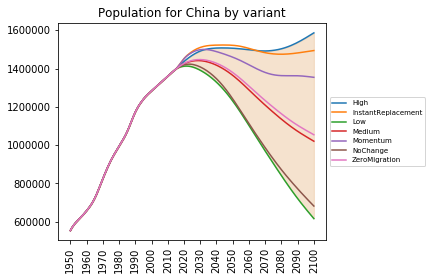

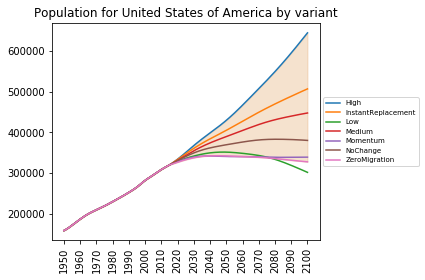

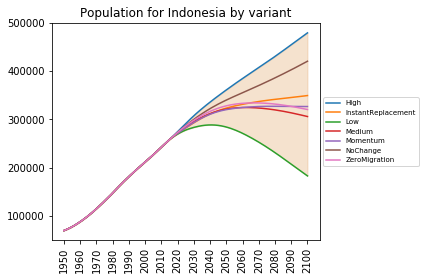

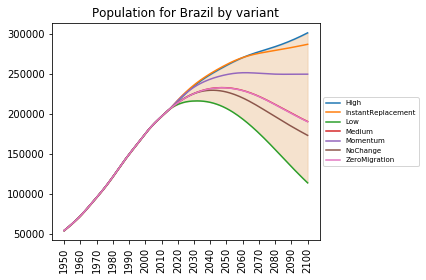

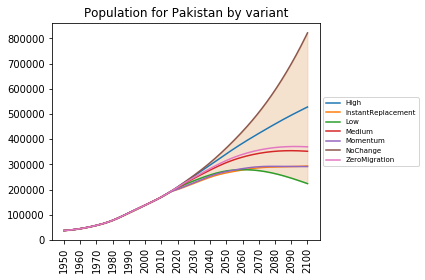

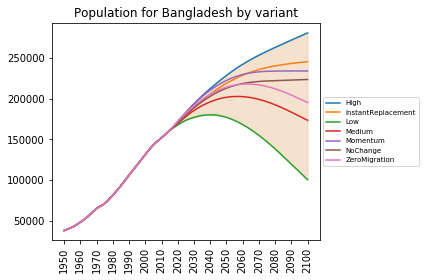

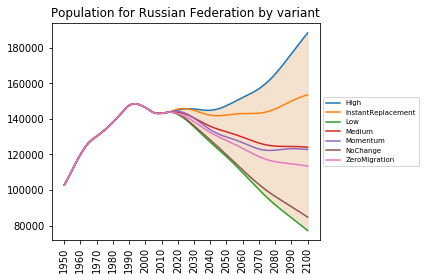

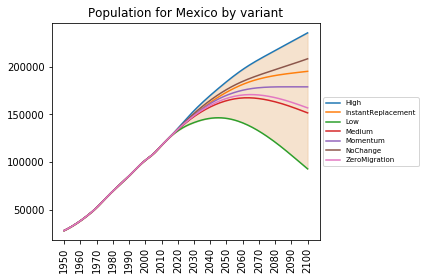

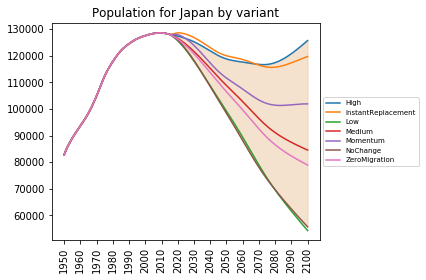

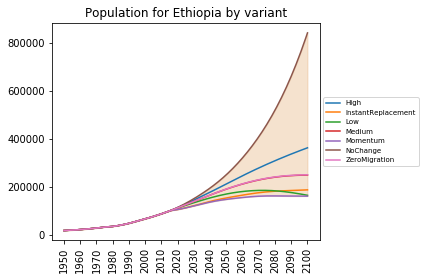

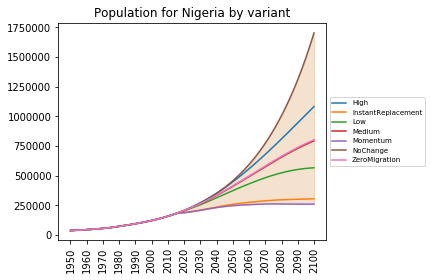

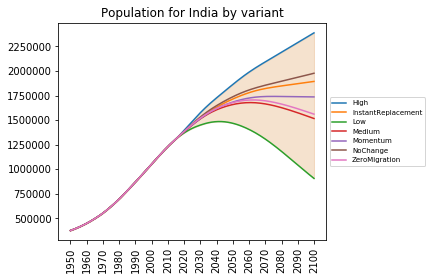

In [21]:
import pandas as pd
# from bokeh.plotting import figure, output_file, show
import matplotlib.pyplot as plt



# ignore "ConstantFertility", "ConstantMortality"
variants = ["High", "InstantReplacement", "Low", "Medium", "Momentum", "NoChange", "ZeroMigration"]

contriesOfInterest = ["China", "United States of America", "Indonesia", "Brazil", "Pakistan",
                      "Bangladesh", "Russian Federation", "Mexico", "Japan", "Ethiopia", "Nigeria", "India","World"]
# top 61% countries from 2020
\

# make sure figs is a real directory
if not os.path.isdir("figs"):
    os.mkdir("figs")

for country in contriesOfInterest:
    xtix = None
    fig, axs = plt.subplots(1, 1)
    # track the highest and lowest variants
    greatestMeanGraphData = ([float("-inf")], [float("-inf")])  # float inf
    smallestMeanGraphData = ([float("inf")], [float("inf")])
    for v in variants:
        gmeta, gdata = getPop(v, country)
        axs.plot(gdata[0], gdata[1], label=v)

        dataMean = sum(gdata[1])/len(gdata[1])
        # set smallest mean data
        smallestMean = sum(smallestMeanGraphData[1])/len(smallestMeanGraphData[1])
        if dataMean < smallestMean:
            smallestMeanGraphData = gdata

        # set largest mean data
        greatestMean = sum(greatestMeanGraphData[1])/len(greatestMeanGraphData[1])
        if dataMean > greatestMean:
            greatestMeanGraphData = gdata

        # set ticks
        if xtix is None:
            xtix = [t for t in gdata[0] if int(t) % 10 == 0]

    # shade between the first line drawn and last line drawn
    # axs.fill_between(firstGraphData[0], firstGraphData[1], lastGraphData[1], alpha=0.3, color="#e0a05f")
    axs.fill_between(smallestMeanGraphData[0], smallestMeanGraphData[1], greatestMeanGraphData[1], alpha=0.3, color="#e0a05f")

    # Shrink current axis by 20%
    box = axs.get_position()
    axs.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # Put a legend to the right of the current axis
    axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={"size": 7})

    axs.set_xticks(xtix)
    plt.title("Population for %s by variant" % (country))
    plt.xticks(rotation=90)
    figname = "figs/popFan_%s" % (country.replace(" ", ""))
    plt.savefig(figname, bbox_inches='tight')
    print("saved figure for %s" % (country))


### Visualization for Fertility rates

####  graph_fert() - Using the smaller csv files, graph the variants and highlight the countries we want

In [17]:
#visualizing population
import re
import random
import pandas as pd
import bokeh.resources
from bokeh.io import export_png
from bokeh.models import Legend
from bokeh.palettes import Set3, Greens, Blues, Reds, Purples
from bokeh.layouts import row, column
from bokeh.models import CustomJS, Slider
from bokeh.plotting import figure, output_file, show, ColumnDataSource


# Function that takes the variant we want to look at and a list of countries we want to highlight and plot
# a line graph of them
def graph_fert(variant, country_names):
# Get the csv file of all the variants and make pandas dataframes for each one. Put it in a dictionary such
# that the key is the variant name and the value is the panda dataframe associated with that key
    to_replace = r'[ -]'
    var_list = ["ESTIMATES", "MEDIUM VARIANT", "HIGH VARIANT", "LOW VARIANT", "CONSTANT-FERTILITY",
    "INSTANT-REPLACEMENT", "MOMENTUM", "ZERO-MIGRATION", "CONSTANT-MORTALITY", "NO CHANGE"]
    keys = []
    for each in var_list:
        keys.append(re.sub(to_replace, "", each.title()))

# Make a dictionary
# How to make a dictionary with just the keys
# https://www.programiz.com/python-programming/methods/dictionary/fromkeys
    dict_list = dict.fromkeys(keys)
    
    for each in keys:
        dict_list[each] = pd.read_csv("data/Fertility_%s.csv" % (each))
    
    variant_fn = re.sub(to_replace, "", variant.title())
    filename = "data/Fertility_%s.csv" % (variant_fn)

    cf = dict_list[variant_fn]
# header_list is the list of the years as in the csv file that we are interested in
    header_list = list(cf.columns.values)[5:]

# Show the country name of the line we are currently hovering over
    TOOLTIPS = [
        ("Country Name", "$name")
    ]

# the headers list is a list of the start and end year, which is of type str. The plot will not work if the list
# is made of strings, so we get the start year by getting the first four characters fromeach item from
# the header_list
    headers = []
    for each in header_list:
        headers.append(each[:4])
    headers = list(map(float,headers))
    
    
# create a new plot with a datetime axis type and the wording we want
    p = figure(plot_width=1000, plot_height=500,title="%s" % (variant.capitalize()), tooltips = TOOLTIPS)
    p.xaxis.axis_label = "Year"
    p.yaxis.axis_label = "Fertility Rate"
    output_file("styling_legend_title.html", title="fertility vs year plot")
    p.legend.title = 'Countries'
    p.legend.title_text_font_style = "bold"
    p.legend.title_text_font_size = "15pt"


# Make a dictionary with the continents and color schemes for each color so it's easily accessible
    all_countries = cf.Location
    Country_Colors = {
        "Americas" : Blues,
        "Africa" : Reds,
        "Asia" : Greens,
        "Europe" : Purples
    }
    
# How to move the legend outside the graph
# https://stackoverflow.com/questions/46730609/position-the-legend-outside-the-plot-area-with-bokeh
    legendd = []
    
    for name in all_countries:
# choose your country and get all the fertility rate values of that country for all the years
        fert = cf.loc[cf["Location"]==name][header_list].values.tolist()[0]
        fert = list(map(float,fert))

# if the country we are on is in the list of countries we want to highlight, color the line according to its
# continent and make the line width bolder
        if(name in country_names):
            continent = cf.loc[cf["Location"] == name]
            continent_colors = continent["region"].values.tolist()[0]
            if variant_fn == "Estimates":
                year_to_look_at = "1950-1955"
            else:
                year_to_look_at = "2020-2025"

            country_fert = continent[year_to_look_at].values.tolist()[0]

            color_one = round(country_fert)+1
            if color_one < 3:
                color_one = 3

            if continent_colors == "Africa":
                color_two = 2
            else:
                color_two = 1
            color = Country_Colors[continent_colors][color_one][color_two]

            c = p.line(headers, fert, color=color, alpha=1, line_width=3, name = name)
            legendd.append((name, [c]))
# If the country is not in the list of countries we are interested in, draw it with a thin width and a grey color
        else:
            color = "#ACACAC"
# make a line graph with the x-axis = header, y = pops, color of the lineis navy, and transparency is 0.5
            p.line(headers, fert, color=color, alpha=0.2, line_width=1, name = name)
    legend = Legend(items=legendd, location=(20, 0))
    p.add_layout(legend, 'right')
    
#     show(p)

    
# Uncomment these next to lines to export the image to the folder we want
# USE ONLY FOR MAKING THE GIFS
    image_location = "tempimages/Fertility_%s.png" % (variant_fn)
    export_png(p, filename=image_location)
    return image_location

#### Plot or make a gif of the fertility graph according to their variants

There will be expected warnings

In [19]:
to_look_at = ["Niger","China", "United States of America","Indonesia", "Brazil","Pakistan", "Bangladesh","Russian Federation", "Mexico", "Japan", "Ethiopia", "Nigeria", "India"]
variant_list = ["ESTIMATES", "MEDIUM VARIANT", "HIGH VARIANT", "LOW VARIANT", "CONSTANT-FERTILITY",
    "INSTANT-REPLACEMENT", "MOMENTUM", "ZERO-MIGRATION", "CONSTANT-MORTALITY", "NO CHANGE"]

changed_vars = ["ESTIMATES", "MEDIUM VARIANT", "HIGH VARIANT", "LOW VARIANT", 
    "INSTANT-REPLACEMENT", "MOMENTUM", "ZERO-MIGRATION", "NO CHANGE"]

def make_fertility_gif():
    initFolders()
    imageList = []
    gifname = "fertility.gif"
    for each in changed_vars:
        imageList.append(graph_fert(each, to_look_at))
    createGif(imageList, gifname, 0.5)
    
make_fertility_gif()
# graph_fert("MEDIUM-VARIANT", to_look_at)


/Users/Srijitha/anaconda3/lib/python3.7/site-packages/bokeh/models/plots.py:55: UserWarning: 
You are attemptings to set `plot.legend.title` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with the 'legend' parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)
/Users/Srijitha/anaconda3/lib/python3.7/site-packages/bokeh/models/plots.py:55: UserWarning: 
You are attemptings to set `plot.legend.title_text_font_style` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with the 'legend' parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)
/Users/Srijitha/anaconda3/lib/python3.7/site-packages/bokeh/models/plots.py:55: UserWarning: 
You are attemptings to set `plot.legend.title_text_font_size` on a plot that has zero legends added, this will have no effect.



[8/8] | processing tempimages/Fertility_NoChange.png 			g 			g 			
gif made at gifs/fertility.gif
Images, temp folder removed


### Choropleth-worldratio

Creates gif for each variant per year where each country is shaded in by the percent it takes up of the world's population.

Note: takes an hour to run

In [20]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

shapefile = 'intermediate-data/ne_10m_admin_0_countries.shp'
#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
#Rename columns.
gdf.columns = ['country', 'country_code', 'geometry']
#gdf
#print(gdf[gdf['country'] == 'Antarctica'])
#Drop row corresponding to 'Antarctica'
gdf = gdf.drop(gdf.index[159])
countrycodefile = 'intermediate-data/all-country-list.csv'
#Read country code list csv file using pandas
cf = pd.read_csv(countrycodefile, names = ['countryname', 'al2', 'al3code','countrycode','iso','region','subr','intr','rcode','subrcode','intrcode'], skiprows = 1)
cf.drop(['iso','region','subr','intr','rcode','subrcode','intrcode'],axis=1,inplace=True)
#cf

variants = ["ConstantFertility", "ConstantMortality", "High", "InstantReplacement", "Low", "Medium", "Momentum", "NoChange", "ZeroMigration"]
years = [str(y) for y in range(1950, 2101)]
variant = "Medium"
#target percent does not change the graph
targetPercent = 0.61 
#going through all of the variants
for variant in variants:
    #creating test files
    initFolders()
    #list of image paths
    imagenames=[]
    for year in years:
        #finds percentage of country's population/ total world population
        cumulativeTotals, topLocations = findTopXPercent(variant, year, targetPercent)
        cumulativeTotals.drop(['Group'], axis=1, inplace=True)
        #print(cumulativeTotals)
        #merging data frames with numerical country code
        halfmerge = cf.merge(cumulativeTotals, left_on = 'countrycode', right_on = 'LocationID')
        #merging data frames with the 3 character country code
        merged = gdf.merge(halfmerge, left_on = 'country_code', right_on = 'al3code')
        print("Variant: %s, year: %s" % (variant, year), end="\r")
        colors =10
        #cmap = 'RdPu'
        #defining color map and only taking subset of the sequential color
        viridisBig = cm.get_cmap('GnBu', 2048)
        newcmp = ListedColormap(viridisBig(np.linspace(0.30, 0.95, 1024)))
        figsize = (16, 10)
        bi = [0.02, 0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24]
        ax = merged.plot(column='Percent', cmap=newcmp, figsize=figsize,scheme='User_Defined',classification_kwds={'bins':bi},k=colors,legend=True)
        ax.set_axis_off()
        leg = ax.get_legend()
        #leg.get_texts()[0].set_text('New label 1')
        #ax.set_xlim([-1.5e7, 1.7e7])
        ax.get_legend().set_bbox_to_anchor((.12, .4))
        plt.title('%s density of total population % s' % (variant, year))
        #saving images
        imgname = "tempimages/densityimage_%s_%s.png" % (variant, year)
        imagenames.append(imgname)
        plt.savefig(imgname, bbox_inches='tight')
        #clear plot
        plt.clf()
    #for each variant call create gif
    gifname = "density_%s.gif" %(variant)
    createGif(imagenames,gifname,0.1)

        country country_code  \
172  Antarctica          ATA   

                                              geometry  
172  (POLYGON ((-51.73064133499992 -82.062556536999...  


/Users/Srijitha/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[151/151] | processing tempimages/densityimage_ConstantFertility_2100.png 			
gif made at gifs/density_ConstantFertility.gif
Images, temp folder removed
[151/151] | processing tempimages/densityimage_ConstantMortality_2100.png 			
gif made at gifs/density_ConstantMortality.gif
Images, temp folder removed
[151/151] | processing tempimages/densityimage_High_2100.png 			
gif made at gifs/density_High.gif
Images, temp folder removed
[151/151] | processing tempimages/densityimage_InstantReplacement_2100.png 			
gif made at gifs/density_InstantReplacement.gif
Images, temp folder removed
[151/151] | processing tempimages/densityimage_Low_2100.png 			
gif made at gifs/density_Low.gif
Images, temp folder removed
[151/151] | processing tempimages/densityimage_Medium_2100.png 			
gif made at gifs/density_Medium.gif
Images, temp folder removed
[151/151] | processing tempimages/densityimage_Momentum_2100.png 			
gif made at gifs/density_Momentum.gif
Images, temp folder removed
[151/151] | processin

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

<Figure size 1152x720 with 0 Axes>

### doughnut.py

Makes a donut plot using the countries of interest's populations with a subplot for male and female breakdown.

Makes a gif over the years of 1950 and 2100.

Note: takes about an hour

In [22]:
# %load doughnut.py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def saveDoughnut(contriesOfInterest, figname, variant, year):

    outsideNames = []
    outsideSize = []
    outsideColors = []
    insideNames = []
    insideSize = []
    intsideColors = []
    colorOffset = 0
    colorSet = [plt.cm.Reds, plt.cm.Blues, plt.cm.Greens, plt.cm.Purples, plt.cm.Oranges]

    for country in contriesOfInterest:
        gmeta, (years, pops) = getAllPops(variant, country, year)
        country = country.replace(" ", "")

        thisColor = colorSet[colorOffset % len(colorSet)]

        outsideNames.append(country)
        outsideSize.append(pops["Total"])
        outsideColors.append(thisColor(0.6))

        insideNames.append("M")
        insideNames.append("F")
        insideSize.append(pops["Male"])
        insideSize.append(pops["Female"])
        intsideColors.append(thisColor(0.4))
        intsideColors.append(thisColor(0.2))

        colorOffset += 1

    # https://python-graph-gallery.com/163-donut-plot-with-subgroups/
    plt.axis('equal')
    mypie, _ = plt.pie(outsideSize, radius=1.3, colors=outsideColors)
    plt.setp(mypie, width=0.3, edgecolor='white')

    mypie2, _ = plt.pie(insideSize, radius=1, labeldistance=0.7, colors=intsideColors)
    plt.setp(mypie2, width=0.4, edgecolor='white')
    plt.margins(0, 0)

    plt.title("Total Population Breakdown | %s | %s" % (variant, year))

    # put labels: https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(mypie):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        plt.annotate(outsideNames[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)

    print("saving %s \t\t\t" % (figname), end="\r")
    plt.savefig(figname, bbox_inches='tight')
    plt.close()
    plt.clf()


variants = ["ConstantFertility", "ConstantMortality", "High", "InstantReplacement", "Low", "Medium", "Momentum", "NoChange", "ZeroMigration"]
contriesOfInterest = ["China", "United States of America", "Indonesia", "Brazil", "Pakistan",
                      "Bangladesh", "Russian Federation", "Mexico", "Japan", "Ethiopia", "Nigeria", "India"]

years = getYears("Medium", "World")  # same for everything

for variant in variants:
    print("making doughnut for %s" % (variant))
    initFolders()
    imageNames = []
    for year in years:
        filename = "tempimages/doughnut_%s_%s.png" % (variant, str(year))
        imageNames.append(filename)
        saveDoughnut(contriesOfInterest, filename, variant, year)

    gifname = "doughnut_%s.gif" % (variant)
    createGif(imageNames, gifname)


making doughnut for ConstantFertility
[151/151] | processing tempimages/doughnut_ConstantFertility_2100.png 			
gif made at gifs/doughnut_ConstantFertility.gif
Images, temp folder removed
making doughnut for ConstantMortality
[151/151] | processing tempimages/doughnut_ConstantMortality_2100.png 			
gif made at gifs/doughnut_ConstantMortality.gif
Images, temp folder removed
making doughnut for High
[151/151] | processing tempimages/doughnut_High_2100.png 			
gif made at gifs/doughnut_High.gif
Images, temp folder removed
making doughnut for InstantReplacement
[151/151] | processing tempimages/doughnut_InstantReplacement_2100.png 			
gif made at gifs/doughnut_InstantReplacement.gif
Images, temp folder removed
making doughnut for Low
[151/151] | processing tempimages/doughnut_Low_2100.png 			
gif made at gifs/doughnut_Low.gif
Images, temp folder removed
making doughnut for Medium
[151/151] | processing tempimages/doughnut_Medium_2100.png 			
gif made at gifs/doughnut_Medium.gif
Images, tem

<Figure size 432x288 with 0 Axes>